# Import and Initialize

In [1]:
import sys, os, time
print("##### Python PATH #####\n",sys.path,"\n#######################\n")

import itertools
import math

import gsd.hoomd
import hoomd

import numpy as np

from hoomd.example_plugin.update import example

import hoomd.respa_plugin
print("##### Plugin PATH #####\n",hoomd.respa_plugin.__file__,"\n#######################\n")

import os

import random as rand

from matplotlib import pyplot

import fresnel
import freud

hoomd.context.initialize('--mode=cpu');

##### Python PATH #####
 ['/mnt/c/Users/rocki/Documents/WORK-Chicago/pythonTest', '/home/ndbarrett/miniconda3/envs/chicago/lib/python39.zip', '/home/ndbarrett/miniconda3/envs/chicago/lib/python3.9', '/home/ndbarrett/miniconda3/envs/chicago/lib/python3.9/lib-dynload', '', '/home/ndbarrett/miniconda3/envs/chicago/lib/python3.9/site-packages'] 
#######################

Importing RESPA plugin. (8/15/2022 11:19PM)
##### Plugin PATH #####
 /home/ndbarrett/miniconda3/envs/chicago/lib/python3.9/site-packages/hoomd/respa_plugin/__init__.py 
#######################

HOOMD-blue v2.9.7-4-g9e74d5e23 DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 07/18/22
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is ru

# Generate Snapshot

In [2]:
Lx = 100
Ly = 50
Lz = 50

dx = 1.2

rand.seed(1)

polymerLength = int(Lx / dx)
numSolv = 2000

numParticles = polymerLength + numSolv

types = [
    "poly",
    "solv"
]

snapshot = hoomd.data.make_snapshot(N=numParticles, particle_types=types, box=hoomd.data.boxdim(Lx,Ly,Lz))



p = [-Lx/2 + 5,0,0]

positions = []
particleTypes = []
velocities = []
maxVel = 0.2
numBonds = polymerLength - 1

snapshot.bonds.resize(numBonds)
snapshot.bonds.types = ["polymer"]

print("Placing Polymer Particles")
posOK = True
for i in range(polymerLength):
    positions.append([p[0],p[1],p[2]])
    velocities.append(list(np.random.uniform(-maxVel,maxVel,3)))
    particleTypes.append("poly")
    
    if i > 0:
        snapshot.bonds.group[i-1] = [i,i-1]
        snapshot.bonds.typeid[i-1] = snapshot.bonds.types.index("polymer")
    
    #Choose a random direction moving in the positive x direction
    ϕ = np.random.uniform(-np.pi/4,np.pi/4)
    θ = np.random.uniform(np.pi/4,3*np.pi/4)
    
    p[0] = (p[0] + dx * np.sin(θ) * np.cos(ϕ) )
    p[1] = ((p[1] + dx * np.sin(θ) * np.sin(ϕ)) + Ly/2) % Ly - Ly/2
    p[2] = ((p[2] + dx * np.cos(θ)            ) + Lz/2) % Lz - Lz/2
    
    if p[0] < -Lx/2 or p[0] > Lx/2:
        print("!! X",i," OUTSIDE BOX !!",p[0]) 
        print("θ:",θ / np.pi * 180,"ϕ:",ϕ / np.pi * 180)
        print("dx:",dx * np.sin(θ) * np.cos(ϕ))
        print("dy:",dx * np.sin(θ) * np.sin(ϕ))
        print("dz:",dx * np.cos(θ))
        posOK = False
        break
    if p[1] < -Ly/2 or p[1] > Ly/2:
        print("!! Y",i," OUTSIDE BOX !!",p[1]) 
        print("θ:",θ / np.pi * 180,"ϕ:",ϕ / np.pi * 180)
        print("dx:",dx * np.sin(θ) * np.cos(ϕ))
        print("dy:",dx * np.sin(θ) * np.sin(ϕ))
        print("dz:",dx * np.cos(θ))
        posOK = False
        break
    if p[2] < -Lz/2 or p[2] > Lz/2:
        print("!! Z",i," OUTSIDE BOX !!",p[2]) 
        print("θ:",θ / np.pi * 180,"ϕ:",ϕ / np.pi * 180)
        print("dx:",dx * np.sin(θ) * np.cos(ϕ))
        print("dy:",dx * np.sin(θ) * np.sin(ϕ))
        print("dz:",dx * np.cos(θ))
        posOK = False
        break
        
if not posOK:
    raise Exception("POSITIONS ARE NOT OKAY")
        
print("Placing Solvent Particles")
availPos = []
numPer = 20
buffer = 5
for xi in np.linspace(-Lx/2 + buffer,Lx/2 - buffer,numPer):
    for yi in np.linspace(-Ly/2 + buffer,Ly/2 - buffer,numPer):
        for zi in np.linspace(-Lz/2 + buffer,Lz/2 - buffer,numPer):
            valid = True
            for pj in positions:
                d = np.sqrt((pj[0] - xi)**2 + (pj[1] - yi)**2 + (pj[2] - zi)**2)
                if d < dx:
                    valid = False
                    break
            
            if valid:
                availPos.append([xi,yi,zi])
                
print(len(availPos)," solvent positions available")
if len(availPos) < numSolv:
    
    raise Exception("Error! Not enough room for solvent!")
                
for i in range(numSolv):
    positions.append(availPos.pop(np.random.randint(0,len(availPos))))
    velocities.append(list(np.random.uniform(-maxVel,maxVel,3)))
    particleTypes.append("solv")

print("Writing data")
mins = [np.infty,np.infty,np.infty]
maxs = [-np.infty,-np.infty,-np.infty]
for i in range(len(positions)):
    #Check positions:
    p = positions[i]
    
    for j in range(3):
        if p[j] < mins[j]:
            mins[j] = p[j]
        if p[j] > maxs[j]:
            maxs[j] = p[j]
    
    if p[0] < -Lx/2 or p[0] > Lx/2:
        print("!! X",i," OUTSIDE BOX !!",p[0]) 
    if p[1] < -Ly/2 or p[1] > Ly/2:
        print("!! Y",i," OUTSIDE BOX !!",p[1]) 
    if p[2] < -Lz/2 or p[2] > Lz/2:
        print("!! Z",i," OUTSIDE BOX !!",p[2]) 
    
    snapshot.particles.position[i] = positions[i]
    snapshot.particles.velocity[i] = velocities[i]
    snapshot.particles.typeid[i] = types.index(particleTypes[i])
    
print("Minimum particles positions:",mins)
print("Maximum particles positions:",maxs)
print("done")

Placing Polymer Particles
Placing Solvent Particles
7981  solvent positions available
Writing data
Minimum particles positions: [-45.0, -20.0, -20.0]
Maximum particles positions: [45.0, 20.0, 20.0]
done


# Initialize Simulation

In [3]:
system = hoomd.init.read_snapshot(snapshot)
file = hoomd.dump.gsd("polymer.gsd", period=25, group=hoomd.group.all(), overwrite=True)
neighList = hoomd.md.nlist.cell()

lj1 = hoomd.md.pair.lj(r_cut=3.0, nlist=neighList)
lj1.pair_coeff.set('poly','poly',epsilon=0.1,sigma=2.0)
lj1.pair_coeff.set('poly','solv',epsilon=0.1,sigma=1.0)
lj1.pair_coeff.set('solv','solv',epsilon=1.4,sigma=1.0) #timestep = σ * sqrt(m / ϵ) * 1e-4

#Note that when adding bond forces, you must also include them
#in the respa integrator definition.
harmBond = hoomd.md.bond.harmonic(name="bond1")
harmBond.bond_coeff.set('polymer', k=1.0, r0=0.9)

integrator = hoomd.respa_plugin.respa_integrator.mode_respa(1e-4,[[lj1,1],[harmBond,10]])
#hoomd.respa_plugin.respa_integrator.mode_respa(0.005,[[lj1,1]])

log1 = hoomd.analyze.log(filename="polymer.log",
                         quantities=['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure',
                                     'pair_lj_energy'],
                         period=100,
                         overwrite=True);

notice(2): Group "all" created containing 2083 particles
FORCE TYPES: <class 'hoomd.md._md.PotentialPairLJ'> <class 'hoomd.md.pair.lj'>
FORCE TYPES: <class 'hoomd.md._md.PotentialBondHarmonic'> <class 'hoomd.md.bond.harmonic'>


# Run Simulation

In [4]:
numSteps = 30000

tStart = time.time()
hoomd.run(numSteps)
tStop = time.time()

dt = tStop - tStart

ans = dt / numSteps / numParticles * 1e9
print("This simulation runs at",ans,"nanoseconds / step / particle")

#Try somthing with 5 beads and some bonds in them


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Particles with 1 exclusions             : 2
notice(2): Particles with 2 exclusions             : 81
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 15193 / 30000 | TPS 1519.25 | ETA 00:00:09
Time 00:00:18 | Step 30000 / 30000 | TPS 1831.88 | ETA 00:00:00
Average TPS: 1658.89
---------
-- Neighborlist stats:
0 normal updates / 0 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 9 / n_neigh_avg: 0.927508
shortest rebuild period: 100
-- Cell list stats:
Dimension: 29, 14, 14
n_min    : 0 / n_max: 7 / n_avg: 0.366467
** run complete **
This simulation runs at 289.65395724302215 nanoseconds / step / particle


# Output Results

### Since the initial structure is highly organized, it is not surprising that total energy fluctuates near the begining of the simulation.

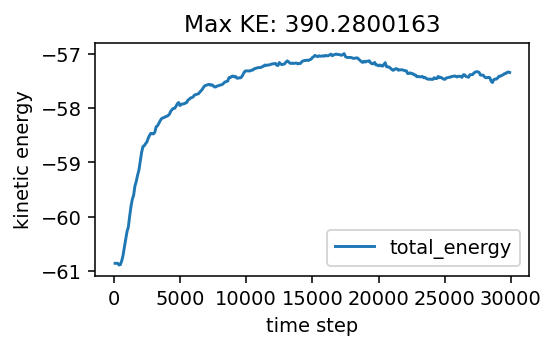

In [5]:
data = np.genfromtxt(fname='polymer.log', skip_header=True)
    
KEs = data[:,6]
PEs = data[:,5]

total = KEs + PEs
    
pyplot.figure(figsize=(4,2.2), dpi=140);
#pyplot.plot(data[1:,0], KEs[1:], label='kinetic_energy');
#pyplot.plot(data[1:,0], PEs[1:], label='potential_energy');
pyplot.plot(data[1:,0], total[1:] - np.average(total[:1]), label='total_energy');
pyplot.title("Max KE: " + str(max(data[:,6])))
pyplot.xlabel('time step');
pyplot.ylabel('kinetic energy');
pyplot.legend(loc='lower right');
pyplot.savefig("KEgraph.png")
pyplot.show()

# Visualization

In [6]:
print("Integrator Schedule:")
integrator.print_schedule()

Integrator Schedule:
Vel Step 1 FC_A
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 1 FC_B
Pos Step
Vel Step 2 FC_B
Vel Step 2 FC_A

